# About the task
The following notebook tries to solve a text calssification task on infection sources. Given a medical note, the model should be able to predict one or more possible infection sources. There are 12 available classes, i.e. 'Abdominal', 'Gastrointestinal', 'Bile duct', 'Urosepsis', 'Catheter-associated', 'Endocarditis', 'Skin and soft tissue', 'Bone and joints', 'Neurological', 'Respiratory', 'Non-identifiable' and  'None of the above'.

The task has been slightly simplified by merging 'implicit' and 'explicit' categories.


# Imports


In [1]:
import pandas as pd
import json

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('C:\\Users\\valif\\OneDrive\\Desktop\\Medical_notes_expl\\Classification\\data\\KINBIOTICS_CLASSIFICATION.csv')
df['implicit_source'] = df['implicit_source'].fillna('None of the above')
df['explicit_source'] = df['explicit_source'].fillna('None of the above')

In the next cell we're formatting the dataset to be multilabel friendly, as each medical note can belong to multiple classes

In [3]:
# Initialize a dictionary to store data for each class
df_class = {
    'text': []  # Initialize a list for storing text data
}

# Define the list of labels
labels_list = ['Abdominal', 'Gastrointestinal', 'Bile duct', 'Urosepsis', 'Catheter-associated', 'Endocarditis',
          'Skin and soft tissue', 'Bone and joints', 'Neurological', 'Respiratory', 'Non-identifiable', 'None of the above']

# For each label, add an empty list to the dictionary
for label in labels_list:
    df_class[label] = []

# Iterate over rows in the main dataframe
for _, row in df.iterrows():
    # Add text data to the 'text' list
    df_class['text'].append(row['text'])

    # Initialize a variable to store the merged result of implicit and explicit sources
    merged = None

    # Extract choices from implicit source, if available
    if 'choices' in row['implicit_source']:
        implicit = json.loads(row['implicit_source'])['choices']
    else:
        implicit = row['implicit_source']

    # Extract choices from explicit source, if available
    if 'choices' in row['explicit_source']:
        explicit = json.loads(row['explicit_source'])['choices']
    else:
        explicit = row['explicit_source']

    # Check if implicit and explicit sources are the same
    if implicit == explicit:
        merged = explicit if type(explicit) == list else [explicit]

    # If implicit and explicit sources are different
    elif implicit != explicit:
        # If implicit source is 'None of the above', choose explicit source
        if implicit == 'None of the above':
            merged = explicit if type(explicit) == list else [explicit]
        else:
            # Otherwise, choose implicit source
            merged = implicit if type(implicit) == list else [implicit]

    # Iterate over labels to build the multilabel
    for label in labels_list:
        # Check if the label is present in the merged sources
        if label in merged:
            df_class[label].append(1)  # Assign 1 if present
        else:
            df_class[label].append(0)  # Assign 0 if not present

# Create a dataframe from the dictionary
df_class = pd.DataFrame(df_class)


In [4]:
df_class.to_csv('multilabel_merged.csv', index=False)

This code is simply to have a better representation of text and labels more useful for the Dataloader used later.


In [6]:
texts= df_class['text']
labs = []

for _, row in df_class.iterrows():
    lab = []
    for label in labels_list:
        lab.append(row[label])
    labs.append(lab)

We used Hugging Face `transformers` library to load the BERT tokenizer (`BertTokenizer`) from the pre-trained `'bert-base-uncased'` model.

We then applied the tokenizer's `batch_encode_plus` method to tokenize and preprocess the input texts (texts). The resulting tokenized data includes input IDs and attention masks.

The tokenized data is then organized into a PyTorch TensorDataset, which is a dataset wrapping tensors.

The dataset is split into training and validation sets using train_test_split from scikit-learn.

Finally, DataLoader objects are created for both the training and validation sets. These data loaders facilitate batching and shuffling of the data during training (shuffle=True for the training loader).

In [8]:
# Tokenize and preprocess the data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Use the tokenizer to encode the input texts
tokenized_data = tokenizer.batch_encode_plus(texts, padding=True, truncation=True, return_tensors='pt')

# Create a PyTorch TensorDataset to hold the tokenized input data and labels
dataset = TensorDataset(
    tokenized_data['input_ids'],        # Input IDs
    tokenized_data['attention_mask'],   # Attention masks
    torch.tensor(labs, dtype=torch.float32)  # Convert labels to torch tensor
)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create DataLoader for training set
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Create DataLoader for validation set
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Training

In [9]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labs[0])
)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
# just a simple function to be used during training to evaluate the model on the validation set after each epoch
def predict(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.sigmoid(logits).cpu().numpy())

    return all_labels, all_preds

In [11]:
# Training
f1s_val = []
f1s_train = []

print('=========== TRAINING STARTS ===========')
print('---------------------------------------')
print('| EPOCH | AVG LOSS | MICRO F1 |  AUC  |')
print('---------------------------------------')
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)

    # Validation
    val_labels, val_preds = predict(model, val_dataloader)

    train_labels, train_preds = predict(model, train_dataloader)

    # Calculate F1 score
    f1_val = f1_score(val_labels, (np.array(val_preds) > 0.5).astype(int), average='micro')
    f1_train = f1_score(train_labels, (np.array(train_preds) > 0.5).astype(int), average='micro')

    f1s_val.append(f1_val)
    f1s_train.append(f1_train)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(val_labels, np.array(val_preds), multi_class='ovr', average='micro')

    # Adjusted print statement for better alignment
    print(f'| {epoch + 1: <5} | {round(average_loss, 3): <8} | {round(f1_val, 3): <8} | {round(roc_auc, 3): <5} |')


print('========== TRAINING COMPLETED =========')


=========== TRAINING STARTS ===========
---------------------------------------
| EPOCH | AVG LOSS | MICRO F1 |  AUC  |
---------------------------------------
| 1     | 0.498    | 0.0      | 0.78  |
| 2     | 0.343    | 0.0      | 0.793 |
| 3     | 0.31     | 0.0      | 0.809 |
| 4     | 0.301    | 0.0      | 0.811 |
| 5     | 0.296    | 0.0      | 0.782 |
| 6     | 0.291    | 0.0      | 0.803 |
| 7     | 0.283    | 0.0      | 0.825 |
| 8     | 0.272    | 0.089    | 0.823 |
| 9     | 0.251    | 0.168    | 0.77  |
| 10    | 0.233    | 0.37     | 0.82  |
| 11    | 0.209    | 0.352    | 0.802 |
| 12    | 0.193    | 0.437    | 0.799 |
| 13    | 0.175    | 0.42     | 0.82  |
| 14    | 0.158    | 0.463    | 0.785 |
| 15    | 0.145    | 0.443    | 0.765 |
| 16    | 0.137    | 0.45     | 0.788 |
| 17    | 0.127    | 0.464    | 0.787 |
| 18    | 0.117    | 0.464    | 0.779 |
| 19    | 0.106    | 0.46     | 0.764 |
| 20    | 0.097    | 0.473    | 0.754 |
| 21    | 0.092    | 0.457    | 0.792 |


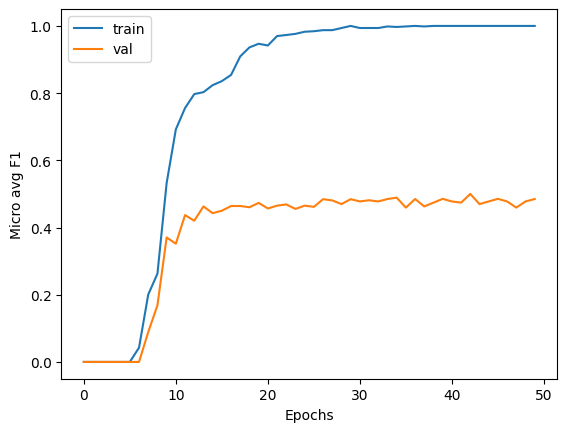

In [12]:
plt.xlabel('Epochs')
plt.ylabel('Micro avg F1')
plt.plot(list(range(50)), f1s_train, label='train')
plt.plot(list(range(50)), f1s_val, label='val')
plt.legend()
plt.show()

From the graph above we can see how after 15 epochs the improvement on the on validation dataset remains mildy fluctuates around 0.47. Continuing to training with the current setting may not be a good idea because the model starts to overfit.

# Evaluation

In [13]:
# Evaluation
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs.logits)
        #print(predictions)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions to binary format
binary_predictions = (np.array(all_predictions) > 0.5).astype(int)

# Evaluate performance
print("Classification Report:")
print(classification_report(all_labels, binary_predictions, zero_division=1))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      0.17      0.25         6
           2       0.57      0.50      0.53         8
           3       0.73      0.44      0.55        25
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         1
           6       0.83      0.38      0.53        13
           7       1.00      0.00      0.00         1
           8       1.00      1.00      1.00         0
           9       0.73      0.58      0.65        19
          10       1.00      0.00      0.00         2
          11       1.00      0.00      0.00         3

   micro avg       0.70      0.37      0.48        86
   macro avg       0.78      0.26      0.29        86
weighted avg       0.71      0.37      0.45        86
 samples avg       0.81      0.44      0.45        86



# On the results:

- micro avg F1 stands at around 0.48 while AUC is around 0.78. This suggest decent performances for the model.
- If we take a look at the micro avg of both precisiona and recal (0.70 \ 0.37 respectively) it's clear how the model tends to be conservative about positive classification.
- Having a high precision and a low recall means that the model is producing more false negatives than false positives. In poor words, the model tends to classifiy as negative an instance unless it has a high confidence on the positive class.
- Confidence can be manually adjusted by adjusting the threshold, hence if a less conservative model is needed one can simply lower the decision threshold, even if a too small threshold will flip the situation. If this happens, one will get a small precision and a high recall.
- We also need to highlight the fact that these perfromances are way better than a random guesser as a baseline. This hypotetical model would score 0.083 for f1 and 0.5 for AUC.

# Application on unlabeled dataset

In [28]:
folder_path= '/content/drive/MyDrive/Colab Notebooks/processed/processed'

results= {
    'text':[],
    'sources': []


}
labels_list = ['Abdominal', 'Gastrointestinal', 'Bile duct', 'Urosepsis', 'Catheter-associated', 'Endocarditis',
          'Skin and soft tissue', 'Bone and joints', 'Neurological', 'Respiratory', 'Non-identifiable', 'None of the above']

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    with open (file_path, 'r') as file:

        new_text = file.read()
        results['text'].append(new_text)


        tokenized_new_text = tokenizer.encode_plus(new_text, padding=True, truncation=True, return_tensors='pt')

        model.eval()
        with torch.no_grad():
            input_ids = tokenized_new_text['input_ids'].to(device)
            attention_mask = tokenized_new_text['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.sigmoid(outputs.logits)

        threshold = 0.5
        binary_prediction = (predictions > threshold).int().cpu().numpy()

        text_labels=[labels_list[i] for i, value in enumerate(binary_prediction[0]) if value == 1]

        if len(text_labels)==0:
          text_labels.append('None of the above')

        results['sources'].append(text_labels)

In [29]:
rpd = pd.DataFrame(results)

In [31]:
rpd.to_csv('MIMIC_infection_source.csv')